In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data

from abtem import GridScan, PixelatedDetector, Potential, Probe, show_atoms, SMatrix, AnnularDetector
from abtem.reconstruct import ptychographic_reconstruction
from ase.build import mx2
from abtem.structures import orthogonalize_cell
from abtem.measure import bandlimit

# Reconstruction of MoS2 using the ePIE algorithm

We simulate a 4D-STEM dataset of MoS2 with a defect and perform a ptychographic reconstruction using the [ePIE](https://doi.org/10.1364/OPTICA.4.000736) algorithm.

## Simulation

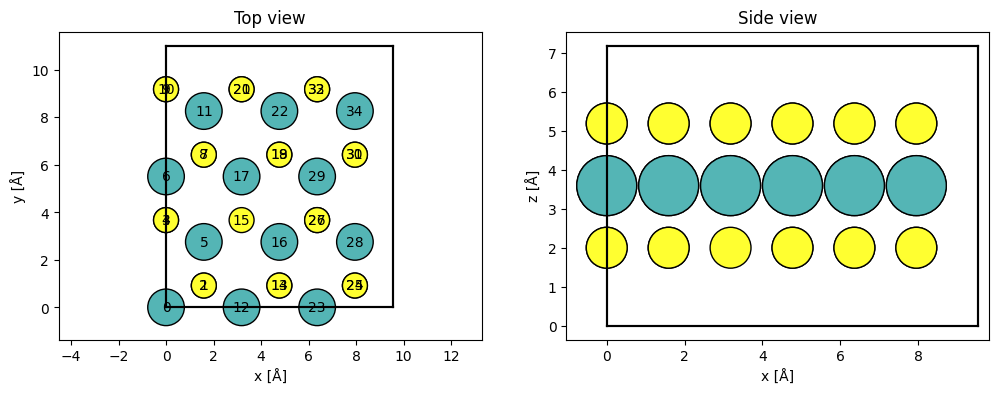

In [4]:
atoms = mx2(formula='MoS2', kind='2H', a=3.18, thickness=3.19, size=(1, 1, 1), vacuum=None)
atoms = orthogonalize_cell(atoms)
atoms.center(vacuum=2, axis=2)

atoms *= (3,2,1)
del atoms[16]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view', numbering=True)
show_atoms(atoms, ax=ax2, plane='xz', title='Side view');

In [5]:
potential = Potential(atoms, 
                      sampling=.05,
                      projection='infinite', 
                      slice_thickness=1, 
                      parametrization='kirkland').build()

S = SMatrix(semiangle_cutoff=30, energy=80e3, expansion_cutoff=30, device='cpu')
S.grid.match(potential)

gridscan = GridScan((0,0), np.array(potential.extent), sampling=.4)
detector = PixelatedDetector()
measurement = S.scan(gridscan, [detector], potential)

Multislice:   0%|          | 0/167 [00:00<?, ?it/s]

Scan:   0%|          | 0/672 [00:00<?, ?it/s]

## Full-field reconstruction

We first do a full-field reconstuction, however, we may still need to bandlimit the measurement to some experimental maximum detector angle.

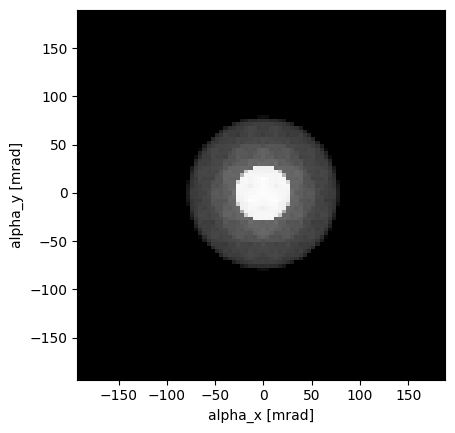

In [9]:
band_limited_measurement = bandlimit(measurement, 80)

band_limited_measurement[0,0].show(power=.25);

We make a probe guess, here we assume that all we know si the probe semi-angle and energy. The probe will be optimized as-well.

In [7]:
probe_guess = Probe(semiangle_cutoff=30, energy=80e3)

In [10]:
reconstructions_full = ptychographic_reconstruction(band_limited_measurement, probe_guess, maxiter=3, return_iterations=True, fix_com=True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/672 [00:00<?, ?it/s]

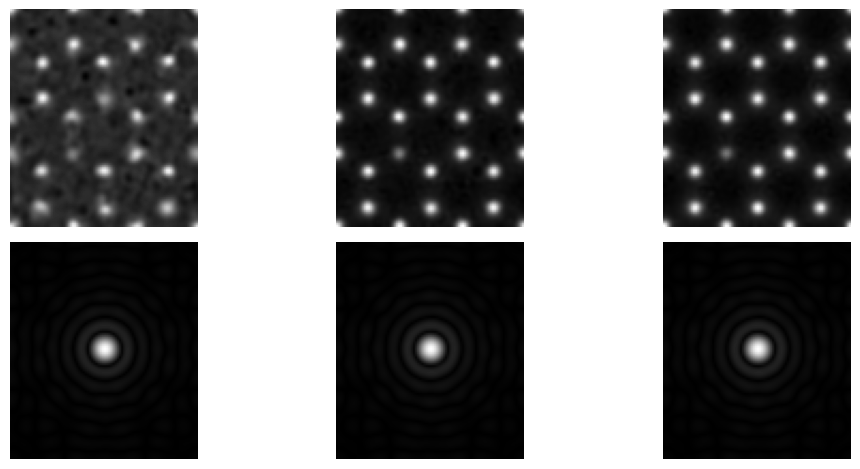

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(11,4.8))

for i in range(3):
    axes[0,i].imshow(np.angle(reconstructions_full[0][i].array).T, origin='lower', cmap='gray')
    axes[1,i].imshow(np.abs(reconstructions_full[1][i].array).T, origin='lower', cmap='gray')
    for ax in (axes[0,i], axes[1,i]):
        ax.axis('off')
    
plt.tight_layout()

## Bright-field reconstruction

Bright-field reconstruction can be performed by simply bandlimiting to the bright-field disk.

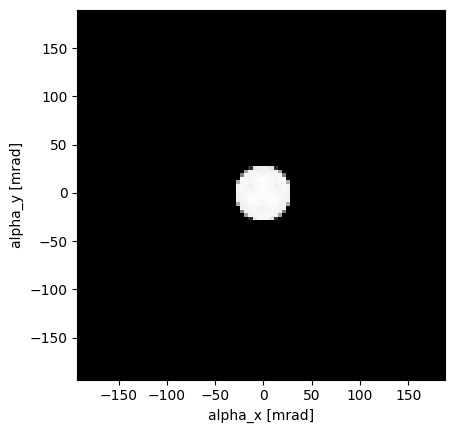

In [13]:
bright_field_measurement = bandlimit(measurement, 30)

bright_field_measurement[0,0].show(power=.25);

We find emperically that for bright-field reconstructions the step sizes of probe and image updates have to be significantly decreased.

In [26]:
reconstructions_bright = ptychographic_reconstruction(bright_field_measurement, probe_guess, maxiter=15, damping=0.15, return_iterations=True, fix_com=True)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/672 [00:00<?, ?it/s]

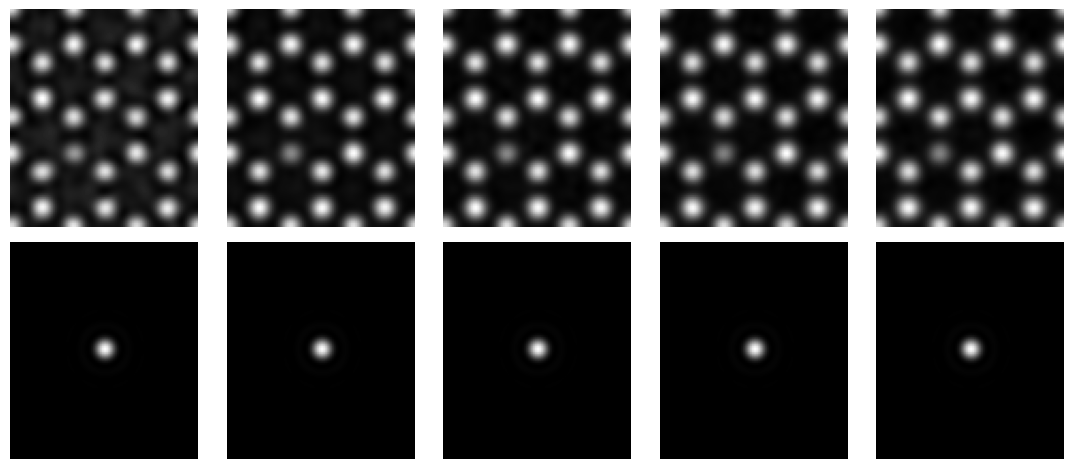

In [27]:
plot_every = 3

fig, axes = plt.subplots(2, int(np.ceil(len(reconstructions_bright[0]) / plot_every)), figsize=(11,4.8))

for i, j in enumerate(range(0, len(reconstructions_bright[0]), plot_every)):
    axes[0,i].imshow(np.angle(reconstructions_bright[0][j].array).T, origin='lower', cmap='gray')
    axes[1,i].imshow(np.abs(reconstructions_bright[1][j].array).T ** 2, origin='lower', cmap='gray')
    for ax in (axes[0,i], axes[1,i]):
        ax.axis('off')
    
plt.tight_layout()